In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Reading the data from the Sqlite file

In [222]:
## download dataset from this location : https://www.kaggle.com/snap/amazon-fine-food-reviews.

In [17]:
sqlobject = sqlite3.connect('./data/database.sqlite')

reviews = pd.read_sql_query("""SELECT Score, Summary FROM Reviews""", sqlobject)


In [18]:
original = reviews.copy()

In [19]:
reviews = original.copy()

In [20]:
print(reviews.shape)

(568454, 2)


In [21]:
reviews = reviews.dropna()

In [22]:
print (reviews.shape)

(568454, 2)


In [23]:
## this is how loaded data looks like

In [24]:
print (reviews.head(25))

    Score                                            Summary
0       5                              Good Quality Dog Food
1       1                                  Not as Advertised
2       4                              "Delight" says it all
3       2                                     Cough Medicine
4       5                                        Great taffy
5       4                                         Nice Taffy
6       5      Great!  Just as good as the expensive brands!
7       5                             Wonderful, tasty taffy
8       5                                         Yay Barley
9       5                                   Healthy Dog Food
10      5                    The Best Hot Sauce in the World
11      5  My cats LOVE this "diet" food better than thei...
12      1               My Cats Are Not Fans of the New Food
13      4                                  fresh and greasy!
14      5                       Strawberry Twizzlers - Yummy
15      5           Lots

### We can see above that there are no missing values

## 2. Encoding score to Positive or negative based on value of each sample

In [25]:
scores = reviews['Score']
#reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

In [26]:
scores.mean()

4.1831986405232433

## 3. Distribution of labels in the dataset

In [27]:
reviews.groupby('Score')['Summary'].count()

Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: Summary, dtype: int64

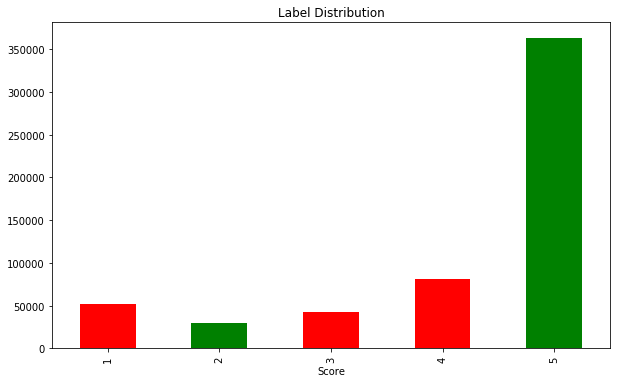

In [28]:
reviews.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','g'],title='Label Distribution',figsize=(10,6))

In [30]:
print ('Percentage of 1 star reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()[1])*100.0/len(reviews)))
print ('Percentage of 2 star reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()[2])*100.0/len(reviews)))
print ('Percentage of 3 star reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()[3])*100.0/len(reviews)))
print ('Percentage of 4 star reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()[4])*100.0/len(reviews)))
print ('Percentage of 5 star reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()[5])*100.0/len(reviews)))

Percentage of 1 star reviews 9.19 %
Percentage of 2 star reviews 5.24 %
Percentage of 3 star reviews 7.50 %
Percentage of 4 star reviews 14.19 %
Percentage of 5 star reviews 63.88 %


### As we can see the data is pretty skewed. We are able to already decide that we must use Stratified Split for evaluation

## 4. Splitting the dataset based on labels

In [31]:
def splitstars(Summaries):
    star1 = reviews.loc[Summaries['Score']==1]
    star2 = reviews.loc[Summaries['Score']==2]
    star3 = reviews.loc[Summaries['Score']==3]
    star4 = reviews.loc[Summaries['Score']==4]
    star5 = reviews.loc[Summaries['Score']==5]
    return [star1,star2,star3,star4,star5]

In [32]:
[star1,star2,star3,star4,star5] = splitstars(reviews)

In [34]:
print(star1)

        Score                                            Summary
1           1                                  Not as Advertised
12          1               My Cats Are Not Fans of the New Food
26          1                                    Nasty No flavor
50          1                                      Don't like it
62          1                                     stale product.
73          1               Warning!  WARNING!  -ALCOHOL SUGARS!
75          1                                      No Tea Flavor
99          1                                                Bad
153         1                                      Rip off Price
164         1                          Tasteless but low calorie
167         1                                   Very Low quality
168         1                                   Not Banana Runts
208         1      These just don't do it for me as breath mints
213         1                CHANGED FORMULA MAKES CATS SICK!!!!
216         1            

## 5. Preprocessing

### Using lemmatization as it was giving better results than stemming. Other steps include removing punctuation amd upper case to lower case conversion.

In [35]:
#preprocessing steps

#stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        #if(t not in stop):
            #stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [37]:
star1_data = []
star2_data = []
star3_data = []
star4_data = []
star5_data = []

for p in star1['Summary']:
    star1_data.append(preprocessing(p))
for p in star2['Summary']:
    star2_data.append(preprocessing(p))
for p in star3['Summary']:
    star3_data.append(preprocessing(p))
for p in star4['Summary']:
    star4_data.append(preprocessing(p))
for p in star5['Summary']:
    star5_data.append(preprocessing(p))    

In [38]:
data = star1_data + star2_data + star3_data + star4_data + star5_data
labels = np.concatenate(( star1['Score'].values, star2['Score'].values, star3['Score'].values, star4['Score'].values, star5['Score'].values))

In [40]:
print(data[0])
print(labels[0])

not a advertised
1


## 6. Splitting the data into train and test using a stratified strategy

In [41]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

In [42]:
## tokenizing the training data to find frequency of words

In [43]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [44]:
word_features = nltk.FreqDist(t)
print (len(word_features))

27050


### We can see that the number of unique words in the dataset is pretty huge. When doing text classification the vocabulary of the data set becomes the featureset.
### We would want to reduce the size of this feature set. This can be done in severals ways.
### One of them is feature reduction using PCA.

## 7. Feature Reduction

### a. Using PCA

In [45]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [46]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [47]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

#### Pca doesn't apply to sparse matrices so we use a different version of PCA called Truncated SVD

In [48]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [49]:
te_features_truncated = svd.transform(te_features_all)

In [50]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

### Running 4 classification algorithms : Naive Bayes, Logistic Regression, Decision Trees and Perceptron

In [51]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
                                                                                                        'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [52]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(tr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(te_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_truncated,Train_labels)
        #cprediction[name] = model.predict(cte_features_truncated)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)

        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_svd.loc[foldnum,'Count Accuracy']=caccuracy
        foldnum = foldnum+1
print (results_svd)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


           Model  TF-IDF Accuracy
0    BernoulliNB         0.648416
1       Logistic         0.682712
2  Decision Tree         0.684697
3     Perceptron         0.626954


In [53]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

          1       0.77      0.06      0.11     13067
          2       0.38      0.03      0.06      7442
          3       0.71      0.04      0.07     10660
          4       0.34      0.00      0.00     20164
          5       0.65      1.00      0.79     90781

avg / total       0.61      0.65      0.52    142114



Classification report for  Logistic
             precision    recall  f1-score   support

          1       0.54      0.32      0.40     13067
          2       0.38      0.06      0.11      7442
          3       0.44      0.17      0.24     10660
          4       0.42      0.09      0.15     20164
          5       0.71      0.98      0.82     90781

avg / total       0.62      0.68      0.61    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

          1       0.54      0.56      0.55     13067
          2       0.37   

In [56]:
print(results_svd)

           Model  TF-IDF Accuracy
0    BernoulliNB         0.648416
1       Logistic         0.682712
2  Decision Tree         0.684697
3     Perceptron         0.626954


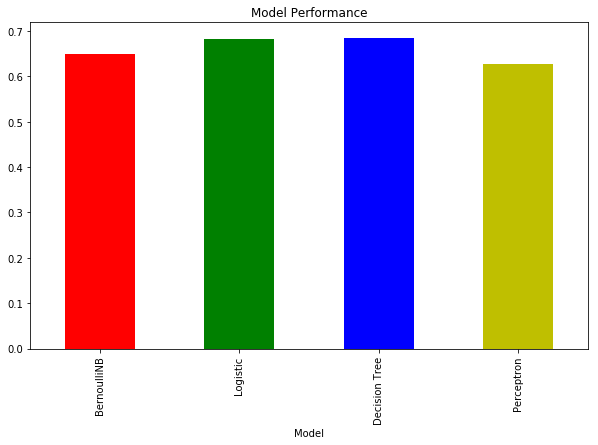

In [58]:
results_svd.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model', y='TF-IDF Accuracy', legend=False)

## 9. Finally we can try by running it on our entire featureset. One can guess it will take a lot of time with Decision Tree Classifier.

### We can make use of group of words to get better results. Sometimes sequence of words might have different effect on the prediction. Sequences like "not good" or "not bad" affect the prediction in way different than when used individually.

### a. Unigram

In [59]:
### using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [60]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [61]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [62]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [63]:
results_all_uni = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_uni.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_uni.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_uni.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_uni)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.709163  BernoulliNB
1         0.727177     Logistic
2         0.629945   Perceptron


In [64]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))

Classification report for  BernoulliNB
             precision    recall  f1-score   support

          1       0.58      0.61      0.60     13067
          2       0.39      0.13      0.20      7442
          3       0.42      0.30      0.35     10660
          4       0.40      0.21      0.27     20164
          5       0.78      0.93      0.85     90781

avg / total       0.66      0.71      0.67    142114

Classification report for  Logistic
             precision    recall  f1-score   support

          1       0.62      0.63      0.62     13067
          2       0.43      0.24      0.31      7442
          3       0.47      0.31      0.37     10660
          4       0.46      0.20      0.27     20164
          5       0.79      0.95      0.86     90781

avg / total       0.68      0.73      0.69    142114

Classification report for  Perceptron
             precision    recall  f1-score   support

          1       0.50      0.49      0.50     13067
          2       0.26      0.25

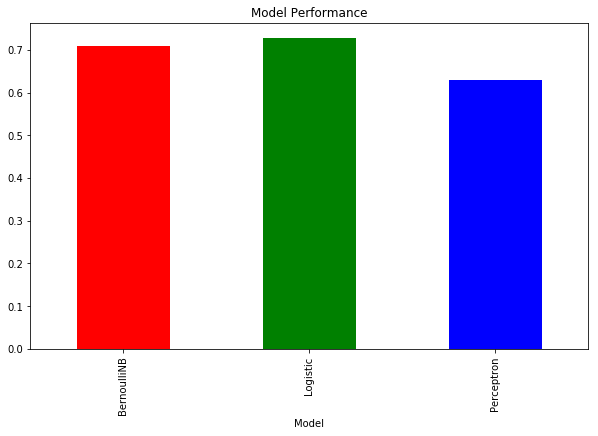

In [66]:
results_all_uni.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model', y='TF-IDF Accuracy',legend=False)

### b. Using Bigrams

In [67]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [68]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [69]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [70]:
print ((ctr_features_all.shape))

(426340, 263650)


In [71]:
results_all_bi = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_bi.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_bi.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_bi.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_bi)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.720872  BernoulliNB
1         0.785334     Logistic
2         0.742291   Perceptron


In [72]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

          1       0.66      0.48      0.56     13067
          2       0.84      0.09      0.17      7442
          3       0.61      0.25      0.36     10660
          4       0.48      0.28      0.35     20164
          5       0.75      0.96      0.84     90781

avg / total       0.70      0.72      0.68    142114



Classification report for  Logistic
             precision    recall  f1-score   support

          1       0.72      0.73      0.72     13067
          2       0.56      0.45      0.50      7442
          3       0.60      0.50      0.55     10660
          4       0.60      0.39      0.47     20164
          5       0.85      0.94      0.89     90781

avg / total       0.77      0.79      0.77    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

          1       0.70      0.63      0.67     13067
          2       0.44      

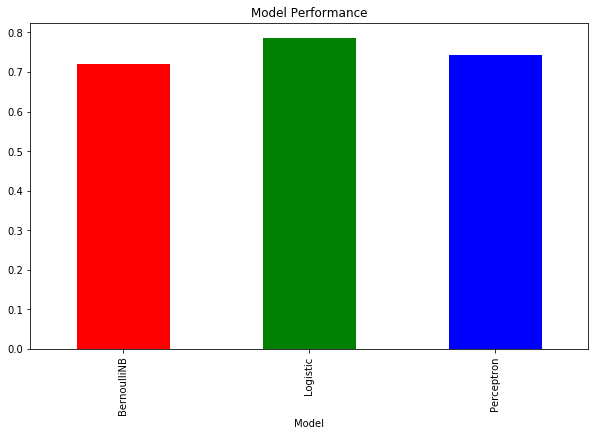

In [74]:
results_all_bi.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model', y='TF-IDF Accuracy', legend=False)

### c. Using Trigrams

In [75]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,3))
ctr_features_all = vec_all.fit_transform(Data_train)

In [76]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [77]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [78]:
results_all_tri = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_tri.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_tri.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_tri.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_tri)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.702141  BernoulliNB
1         0.794763     Logistic
2         0.762346   Perceptron


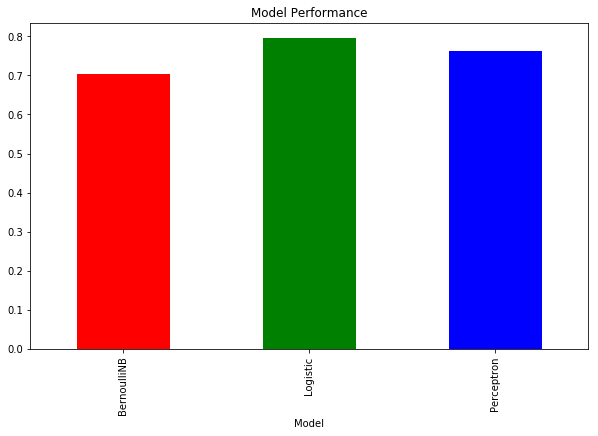

In [82]:
results_all_tri.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model', y='TF-IDF Accuracy',legend=False)

In [80]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

          1       0.74      0.29      0.41     13067
          2       0.96      0.07      0.13      7442
          3       0.78      0.16      0.26     10660
          4       0.54      0.23      0.32     20164
          5       0.71      0.98      0.82     90781

avg / total       0.71      0.70      0.64    142114



Classification report for  Logistic
             precision    recall  f1-score   support

          1       0.72      0.74      0.73     13067
          2       0.58      0.45      0.51      7442
          3       0.62      0.52      0.56     10660
          4       0.63      0.41      0.50     20164
          5       0.85      0.95      0.90     90781

avg / total       0.78      0.79      0.78    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

          1       0.73      0.65      0.69     13067
          2       0.47      

In [225]:
## this code is taken from: https://www.kaggle.com/gpayen/d/snap/amazon-fine-food-reviews/building-a-prediction-model

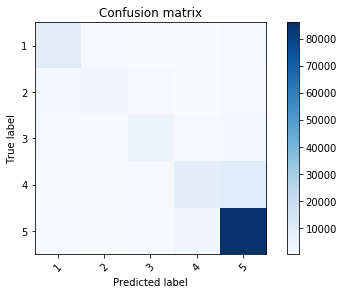

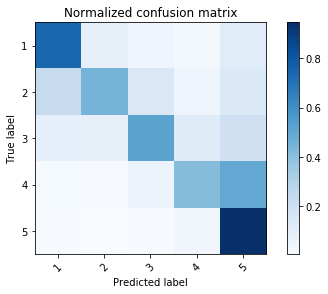

In [84]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(labels)))
    plt.xticks(tick_marks, [1,2,3,4,5], rotation=45)
    plt.yticks(tick_marks, [1,2,3,4,5])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Test_labels, tfprediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
## Thank you